In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [8]:
class galerkin_bim:
    def __init__(self, n, a, b, lam, x1, x2, rhs):
        
        self.n = n
        self.a = a
        self.b = b
        self.lam = lam
        
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        self.x1 = x1(self.s)
        self.x2 = x2(self.s)
        self.y1 = x1(self.t)
        self.y2 = x2(self.t)
        
        # initialize h for quadrature to find u
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n+1,n+1))
        self.rhs_values = np.zeros(n+1)
        self.mu = np.zeros(n+1)
        #self.t_values = np.zeros(n+1)
        #self.weights = np.zeros(n+1)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
        self.jacobian_lam = 0
        self.dgreens_dn_lam = 0
        self.kappa_lam = 0
        
    
    def lagrange_poly_value(self, n_in, i, t_in):
        # evaluates the ith Lagrange polynomial on [a,b] with n_in nodes at the point t_in
        h_in = (self.b - self.a) / n_in
        #self.lagrange_poly = 0
        #self.lagrange_poly_lam = 0
        
        if (i != 0 and i != n_in):
            self.lagrange_poly = sp.Piecewise((0, self.t < self.a + (i-1) * h_in), (0, self.t > self.a + (i+1)*h_in), (1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        if (i == 0):
            self.lagrange_poly = sp.Piecewise((0,self.t > self.a + (i+1)*h_in),(1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        if (i == n_in):
            self.lagrange_poly = sp.Piecewise((0,self.t < self.a + (i-1)*h_in),(1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        
        return self.lagrange_poly_lam(t_in)
    
    
    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to composite trapezoid nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in+1):
            t_values[i] = self.a + i*h_in
        
        return t_values

            
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;
        
        return weights
        
        
    def construct_greens_function(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)

        # normal vector in 2D
        self.normal = (1/self.jacobian) * sp.Array([-1*sp.diff(self.y2,self.t),sp.diff(self.y1,self.t)])

        # greens function and normal derivative
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
        self.del_greens_fxn = sp.Array([-1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x1-self.y1),
                                        -1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x2-self.y2)])
        self.dgreens_dn = self.del_greens_fxn[0] * self.normal[0] + self.del_greens_fxn[1] * self.normal[1]
        self.dgreens_dn_simplified = sp.simplify(self.dgreens_dn)
        self.dgreens_dn_lam = sp.lambdify([self.t,self.s],self.dgreens_dn_simplified)
        # order for inputs is (t,s)

        # for the case where the kernel is nearly singular
        self.kappa = (-1/(4*np.pi))*(sp.diff(self.y2,self.t,self.t)*sp.diff(self.y1,self.t)-sp.diff(self.y1,self.t,self.t)*sp.diff(self.y2,self.t))*(1/(sp.Pow(sp.diff(self.y1,self.t),2)+sp.Pow(sp.diff(self.y2,self.t),2)))
        self.kappa_lam = sp.lambdify(self.t,self.kappa)
        
            
    def build_linear_system(self):
        # build matrix and rhs
        
        # define the finer grid to evaluate all integrals that form the coefficients of the linear system
        n_fine = 2*self.n
        h_fine = (self.b - self.a) / n_fine
        fine_weights = self.get_trap_weights(n_fine)
        fine_t_values = self.get_t_values(n_fine)
        
        # first build the rhs
        # this is the function y defined symbolically
        self.y_lam = sp.lambdify(self.t,self.rhs)
        
        for i in range(0, self.n + 1):
            # do composite trap rule to evaluate the integral numberically on a finer grid to avoid problems with
            # compact support of the Lagrange polynomials
            rhs_val = 0
            for j in range(0, n_fine + 1):
                rhs_val = rhs_val + self.y_lam(fine_t_values[j]) * self.lagrange_poly_value(n_fine, j, fine_t_values[j]) * fine_weights[j]
            
            self.rhs_values[i] = rhs_val
        
        # next build the matrix, build the two parts separately and adding them together in the end
        
        # build the lam(li,lj) part first
        matrix_1 = np.zeros((self.n+1,self.n+1))
        for i in range(0,self.n + 1):
            for j in range(0,self.n + 1): 
                if (sp.Abs(i-j) > 1):
                    matrix_1[i,j] = 0
                elif (i == j and i > 0 and i < self.n):
                    matrix_1[i,j] = (2/3)*self.h
                elif (i == j and i == 0):
                    matrix_1[i,j] = (1/3)*self.h
                else:
                    matrix_1[i,j] = (1/6)*self.h
                    
        matrix_1 = matrix_1 * self.lam
        
        # now build the matrix of the double integral term
        matrix_2 = np.zeros((self.n+1,self.n+1))
        for i in range(0,self.n + 1):
            for j in range(0,self.n + 1):
                sum_inner = 0
                sum_outer = 0
                for p in range(0, n_fine + 1):
                    for k in range(0, n_fine + 1):
                        sum_inner = sum_inner + self.dgreens_dn_lam(fine_t_values[p],fine_t_values[k]) * self.lagrange_poly_value(n_fine, j, fine_t_values[k]) * fine_weights[k]
                    
                    sum_outer = sum_outer + sum_inner * self.lagrange_poly_value(n_fine, i, fine_t_values[p]) * fine_weights[p]
                
                matrix_2[i,j] = sum_outer
        
        # combine the matrices
        self.matrix = matrix_1 - matrix_2
        
    def solve_mu(self):
        # solve the linear system for mu
        self.mu = np.linalg.inv(self.matrix)@self.rhs_values
        return self.mu
    
    

In [9]:
q,r = sp.symbols("q r")

#q,r are dummy variables for x1 and x2
rhs = sp.exp(q)*sp.cos(r)
N = 5

a = 0
b = 2*np.pi
lam = -0.5

x1 = sp.cos
x2 = sp.sin

gal = galerkin_bim(N, a, b, lam, x1, x2, rhs)
gal.construct_greens_function()
gal.build_linear_system()
mu = gal.solve_mu()

In [10]:
print(gal.matrix)

[[-0.20158553 -0.08901179  0.01570796  0.01570796  0.01570796  0.01570796]
 [-0.07330383 -0.35604717 -0.0418879   0.06283185  0.06283185  0.06283185]
 [ 0.04712389 -0.01047198 -0.32463124 -0.01047198  0.09424778  0.09424778]
 [ 0.06283185  0.12566371  0.02094395 -0.29321531  0.02094395  0.12566371]
 [ 0.07853982  0.15707963  0.15707963  0.05235988 -0.26179939  0.05235988]
 [ 0.09424778  0.18849556  0.18849556  0.18849556  0.0837758   0.0837758 ]]


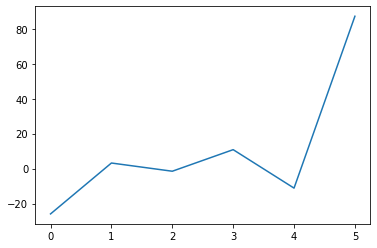

In [11]:
plt.plot(mu)